In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()
sns.set_style("whitegrid")

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [50]:
# define function to generate new column "age"
def get_ages(x):
    x_new = 2021 - x
    return x_new

In [52]:
################ Preprocessing ####################

# Function to get the filtered data set
def get_data():

    # usage of pathlib
    #PROJECT_DIR = Path(__file__).parent
    #path = PROJECT_DIR / 'data/autoscout24.csv'
    data = pd.read_csv('autoscout24.csv')

    return data

# Function to get data without nan-values
def get_data_without_na(data):

    # drop NaN values from features with object-type: "model" and "gear" 
    data = data.dropna(subset=["model", "gear"])

    # replace NaN values from features with numeric-type with median value: "hp"
    data["hp"] = data["hp"].fillna(data["hp"].median())

    return data

In [53]:
# Initialise preprocessed data without nan values for machine learning
dataml = get_data_without_na(get_data())

In [54]:
# add new column "age" in ml dataset 
dataml["age"] = dataml["year"].apply(get_ages)



The model performance for test set
--------------------------------------
MAE: 2894.4949069847066
MSE: 88207668.07191877
RMSE: 9391.893742580289
R2 score is 0.7619309089401498


The model performance for training set
--------------------------------------
R2 score is 0.9577508219946083




C:\Users\Oliver\AppData\Local\Temp\ipykernel_59128\3498774242.py:63: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))


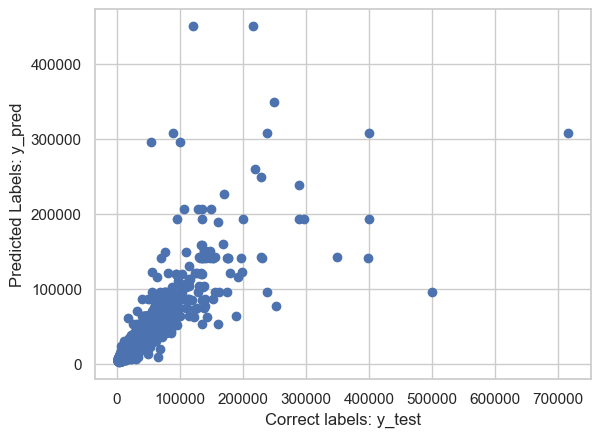

In [47]:
### Decision Tree Regression with dummys  ###

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the dummies for the categorical variables
X = pd.get_dummies(data=X, columns=["make"], prefix="make", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["model"], prefix="model", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["fuel"], prefix="fuel", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["gear"], prefix="gear", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["offerType"], prefix="offerType", dtype=float, drop_first=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# Initialise the model for Decision Tree Regression
tree = DecisionTreeRegressor(max_depth=10, random_state=100)

# Train model
tree.fit(X_train, y_train)

# Make predictions
y_pred = tree.predict(X_test)

# Visualisation of the correct vs. predicted labels 
plt.scatter(y_test, y_pred)
plt.xlabel('Correct labels: y_test')
plt.ylabel('Predicted Labels: y_pred')
print("\n")

# Model performance for test data set:
r2 = r2_score(y_test, y_pred) # Calculation of the R² coefficient of determination

print("The model performance for test set")
print("--------------------------------------")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # Calculation of the RMSE error measure
print('R2 score is {}'.format(r2))
print("\n")

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2_score(y_train, tree.predict(X_train))))
print("\n")


# create a new dataframe with correct and predicted values 
corr_vs_pred = pd.DataFrame({
    "correct": y_test.squeeze(),
    "predicted": y_pred.squeeze()
}).reset_index(drop=True)

# create a new dataframe with metric values
metric_values = pd.DataFrame({
    "MAE": metrics.mean_absolute_error(y_test, y_pred).round(2),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
    "R-squared in %": (r2_score(y_test, y_pred) * 100).round(2)
}, index=[0])

# thousand seperator
metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))

# saving the results into csv file. this is used for visualization later on machine learning
corr_vs_pred.to_csv("tree_reg_evaluation_data.csv")
metric_values.to_csv("tree_reg_metrics.csv")

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the dummies for the categorical variables
X = pd.get_dummies(data=X, columns=["make"], prefix="make", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["model"], prefix="model", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["fuel"], prefix="fuel", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["gear"], prefix="gear", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["offerType"], prefix="offerType", dtype=float, drop_first=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# format y_train
y_train = y_train.squeeze()

# Optimisation of parameters through grid search
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']
print(best_max_depth)

KeyboardInterrupt: 



The model performance for test set
--------------------------------------
MAE: 2570.234014854177
MSE: 74419657.43452075
RMSE: 8626.682875504393
R2 score is 0.7991442173941559


The model performance for training set
--------------------------------------
R2 score is 0.9540124480363356




C:\Users\Oliver\AppData\Local\Temp\ipykernel_59128\225677105.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))


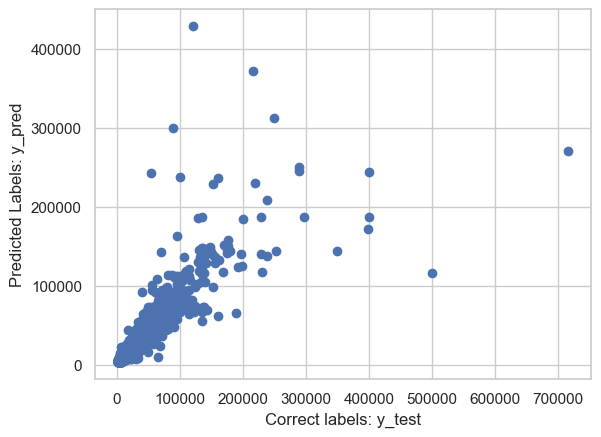

In [56]:
### RandomForest Regression - with dummys  ###

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the dummies for the categorical variables
X = pd.get_dummies(data=X, columns=["make"], prefix="make", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["model"], prefix="model", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["fuel"], prefix="fuel", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["gear"], prefix="gear", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["offerType"], prefix="offerType", dtype=float, drop_first=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# Initialise the model for RandomForest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)

# format y_train
y_train = y_train.squeeze()

# Train the model:
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Visualisation of the correct vs. predicted labels
plt.scatter(y_test, y_pred)
plt.xlabel('Correct labels: y_test')
plt.ylabel('Predicted Labels: y_pred')
print("\n")

# Model performance for test data set:
r2 = r2_score(y_test, y_pred) # Calculation of the R² coefficient of determination

print("The model performance for test set")
print("--------------------------------------")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # Calculation of the RMSE error measure
print('R2 score is {}'.format(r2))
print("\n")

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2_score(y_train, rf.predict(X_train))))
print("\n")

# create a new dataframe with correct and predicted values 
corr_vs_pred = pd.DataFrame({
    "correct": y_test.squeeze(),
    "predicted": y_pred.squeeze()
}).reset_index(drop=True)

# create a new dataframe with metric values
metric_values = pd.DataFrame({
    "MAE": metrics.mean_absolute_error(y_test, y_pred).round(2),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
    "R-squared in %": (r2_score(y_test, y_pred) * 100).round(2)
}, index=[0])

# thousand seperator
metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))

# saving the results into csv file. this is used for visualization later on machine learning
corr_vs_pred.to_csv("randomforest_reg_evaluation_data.csv")
metric_values.to_csv("randomforest_reg_metrics.csv")



The model performance for test set
--------------------------------------
MAE: 2062.8675154066004
MSE: 73071883.96713619
RMSE: 8548.209401221766
R2 score is 0.8027818059547469


The model performance for training set
--------------------------------------
R2 score is 0.9906096216422766




C:\Users\Oliver\AppData\Local\Temp\ipykernel_59128\2106727281.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))


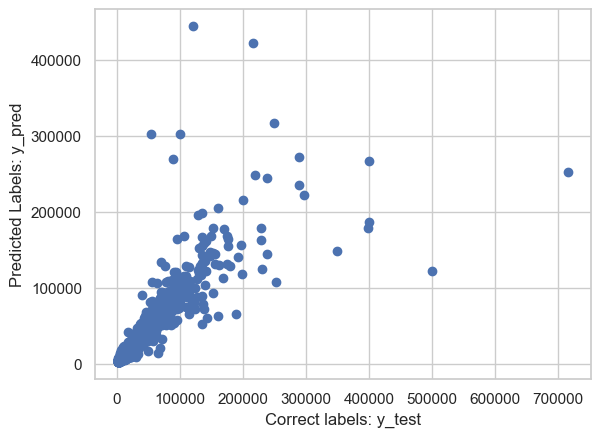

In [68]:
### GB Regression - with dummys  ###

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the dummies for the categorical variables
X = pd.get_dummies(data=X, columns=["make"], prefix="make", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["model"], prefix="model", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["fuel"], prefix="fuel", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["gear"], prefix="gear", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["offerType"], prefix="offerType", dtype=float, drop_first=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# Initialise the model for Gradient Boosting Regression
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=10)

# format y_train
y_train = y_train.squeeze()

# Train the model:
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_test)

# Visualisation of the correct vs. predicted labels
plt.scatter(y_test, y_pred)
plt.xlabel('Correct labels: y_test')
plt.ylabel('Predicted Labels: y_pred')
print("\n")

# Model performance for test data set:
r2 = r2_score(y_test, y_pred) # Calculation of the R² coefficient of determination

print("The model performance for test set")
print("--------------------------------------")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # Calculation of the RMSE error measure
print('R2 score is {}'.format(r2))
print("\n")

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2_score(y_train, gbr.predict(X_train))))
print("\n")

# create a new dataframe with correct and predicted values 
corr_vs_pred = pd.DataFrame({
    "correct": y_test.squeeze(),
    "predicted": y_pred.squeeze()
}).reset_index(drop=True)

# create a new dataframe with metric values
metric_values = pd.DataFrame({
    "MAE": metrics.mean_absolute_error(y_test, y_pred).round(2),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
    "R-squared in %": (r2_score(y_test, y_pred) * 100).round(2)
}, index=[0])

# thousand seperator
metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))

# saving the results into csv file. this is used for visualization later on machine learning
corr_vs_pred.to_csv("gb_reg_evaluation_data.csv")
metric_values.to_csv("gb_reg_metrics.csv")



The model performance for test set
--------------------------------------
MAE: 2028.218220456224
MSE: 59160100.0058751
RMSE: 7691.560310228029
R2 score is 0.8403291738318579


The model performance for training set
--------------------------------------
R2 score is 0.9893537969185807




C:\Users\Oliver\AppData\Local\Temp\ipykernel_59128\12683397.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))


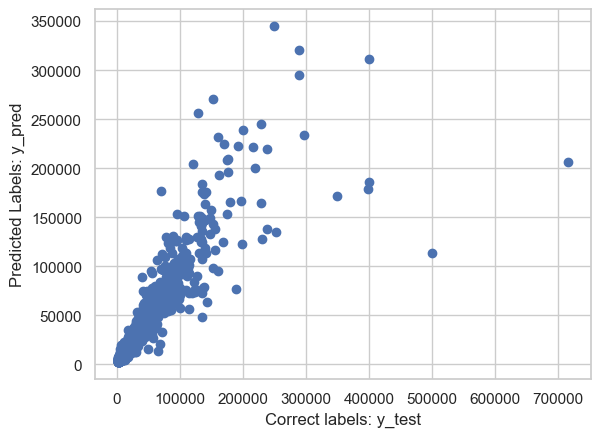

In [67]:
### XGB Regression - with dummys  ###

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the dummies for the categorical variables
X = pd.get_dummies(data=X, columns=["make"], prefix="make", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["model"], prefix="model", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["fuel"], prefix="fuel", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["gear"], prefix="gear", dtype=float, drop_first=True)
X = pd.get_dummies(data=X, columns=["offerType"], prefix="offerType", dtype=float, drop_first=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# Initialise the model for Extreme Gradient Boosting Regression
xgbr = XGBRegressor(n_estimators=100, random_state=42, max_depth=10)

# format y_train
y_train = y_train.squeeze()

# Train the model:
xgbr.fit(X_train, y_train)

# Make predictions
y_pred = xgbr.predict(X_test)

# Visualisation of the correct vs. predicted labels
plt.scatter(y_test, y_pred)
plt.xlabel('Correct labels: y_test')
plt.ylabel('Predicted Labels: y_pred')
print("\n")

# Model performance for test data set:
r2 = r2_score(y_test, y_pred) # Calculation of the R² coefficient of determination

print("The model performance for test set")
print("--------------------------------------")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # Calculation of the RMSE error measure
print('R2 score is {}'.format(r2))
print("\n")

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2_score(y_train, xgbr.predict(X_train))))
print("\n")

# create a new dataframe with correct and predicted values 
corr_vs_pred = pd.DataFrame({
    "correct": y_test.squeeze(),
    "predicted": y_pred.squeeze()
}).reset_index(drop=True)

# create a new dataframe with metric values
metric_values = pd.DataFrame({
    "MAE": metrics.mean_absolute_error(y_test, y_pred).round(2),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
    "R-squared in %": (r2_score(y_test, y_pred) * 100).round(2)
}, index=[0])

# thousand seperator
metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))

# saving the results into csv file. this is used for visualization later on machine learning
corr_vs_pred.to_csv("xgb_reg_evaluation_data.csv")
metric_values.to_csv("xgb_reg_metrics.csv")

c:\Users\Oliver\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Oliver\AppData\Local\Temp\ipykernel_49180\197538926.py:67: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))




The model performance for test set
--------------------------------------
MAE: 2028.218220456224
MSE: 59160100.0058751
RMSE: 7691.560310228029
R2 score is 0.8403291738318579


The model performance for training set
--------------------------------------
R2 score is 0.9893537969185807




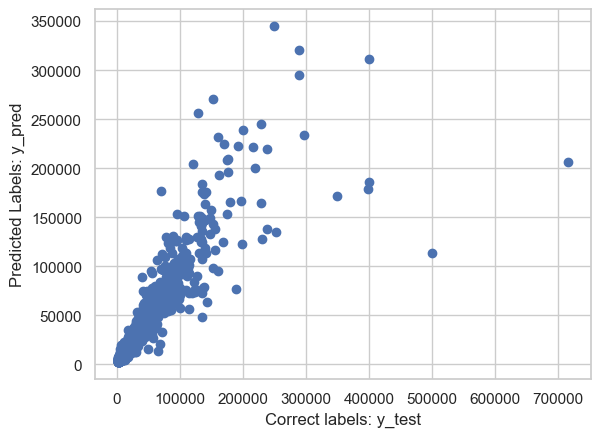

In [8]:
### XGB Regression - with standardisation + dummys by onehotencoder  ###

# Define the features(X) and the label(y)
X = dataml[["mileage", "hp", "age", "make", "model", "fuel", "gear", "offerType"]].reset_index(drop=True)
y = dataml[["price"]].reset_index(drop=True)

# Create the training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# Preprocessing for categorical and numerical data using sklearn ColumnTransformer model
preprocessor = ColumnTransformer(transformers= [
        ("num", StandardScaler(), ["mileage", "hp", "age"]),
        ("cat", OneHotEncoder(handle_unknown="ignore",drop='first'),["make", "model", "fuel", "gear", "offerType"])
    ]
    )
# create a pipeline that combines preprocessing and model training 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, max_depth=10))
])

# format y_train
y_train = y_train.squeeze()

# fit the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Visualisation of the correct vs. predicted labels
plt.scatter(y_test, y_pred)
plt.xlabel('Correct labels: y_test')
plt.ylabel('Predicted Labels: y_pred')
print("\n")

# Model performance for test data set:
r2 = r2_score(y_test, y_pred) # Calculation of the R² coefficient of determination

print("The model performance for test set")
print("--------------------------------------")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # Calculation of the RMSE error measure
print('R2 score is {}'.format(r2))
print("\n")

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2_score(y_train, pipeline.predict(X_train))))
print("\n")

# create a new dataframe with correct and predicted values 
corr_vs_pred = pd.DataFrame({
    "correct": y_test.squeeze(),
    "predicted": y_pred.squeeze()
}).reset_index(drop=True)

# create a new dataframe with metric values
metric_values = pd.DataFrame({
    "MAE": metrics.mean_absolute_error(y_test, y_pred).round(2),
    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
    "R-squared in %": (r2_score(y_test, y_pred) * 100).round(2)
}, index=[0])

# thousand seperator
metric_values = metric_values.applymap(lambda x: '{:,.2f}'.format(x))

# saving the results into csv file. this is used for visualization later on machine learning
corr_vs_pred.to_csv("xgb_reg_evaluation_data.csv")
metric_values.to_csv("xgb_reg_metrics.csv")